# Step 1: 清洗数据，转换数据格式

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd


In [5]:
dataPath = Path("D:\\projects\\2022-01 Graduation\\仿真振动信号数据")
files = [file for file in dataPath.iterdir() if "sum" not in file.name]
out_file = dataPath / "vibration_sum.xlsx"
writer = pd.ExcelWriter(out_file)

for file in files:
    with open(file, encoding='utf-8') as temp_f:
        col_count = [len(l.split(",")) for l in temp_f.readlines()]

    column_names = [i for i in range(max(col_count))]
    data = pd.read_csv(file, skip_blank_lines=True, error_bad_lines=False, names=column_names)
    labels = data.iloc[len(data) - 2, :]
    signals = data.iloc[len(data) - 1, :]
    time_series = []
    for label in labels:
        if "ppb" not in label: continue
        cur_time = label.split("t=")[-1]
        if len(time_series) == 0 or time_series[len(time_series) - 1] != cur_time:
            time_series.append(cur_time)
    signals_reformat = pd.DataFrame(columns=['x', 'y', 'z'], index=time_series)
    for i, signal in enumerate(signals):
        label = labels[i]
        cur_time = label.split("t=")[-1]
        if "ppb1" in label:
            signals_reformat.loc[cur_time, 'x'] = signal
        elif "ppb2" in label:
            signals_reformat.loc[cur_time, 'y'] = signal
        else:
            signals_reformat.loc[cur_time, 'z'] = signal

    signals_reformat.to_excel(writer, sheet_name=file.stem)

writer.save()
writer.close()

D:\Programming\Anaconda3\envs\py38-pt18\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


# Step 2: 读取数据，绘制图像

In [3]:
import numpy as np
import pandas as pd
from pylab import *
from palettable.colorbrewer.qualitative import Set2_7
import h5py
from pathlib import Path
from domainbed.lib import FFT
from scipy import signal
from scipy.interpolate import interp2d
import scipy.io as scio

olors = Set2_7.mpl_colors

params = {
    'axes.labelsize': 8,
    'font.size': 8,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': False,
    'figure.figsize': [4.5, 4.5]
}
rcParams.update(params)
plt.style.use(['science', 'no-latex', 'cjk-sc-font'])

In [7]:
dataPath = Path("D:\\projects\\2022-01 Graduation\\仿真振动信号数据")
file = dataPath / "vibration_sum.xlsx"

data = pd.read_excel(file, sheet_name=None)

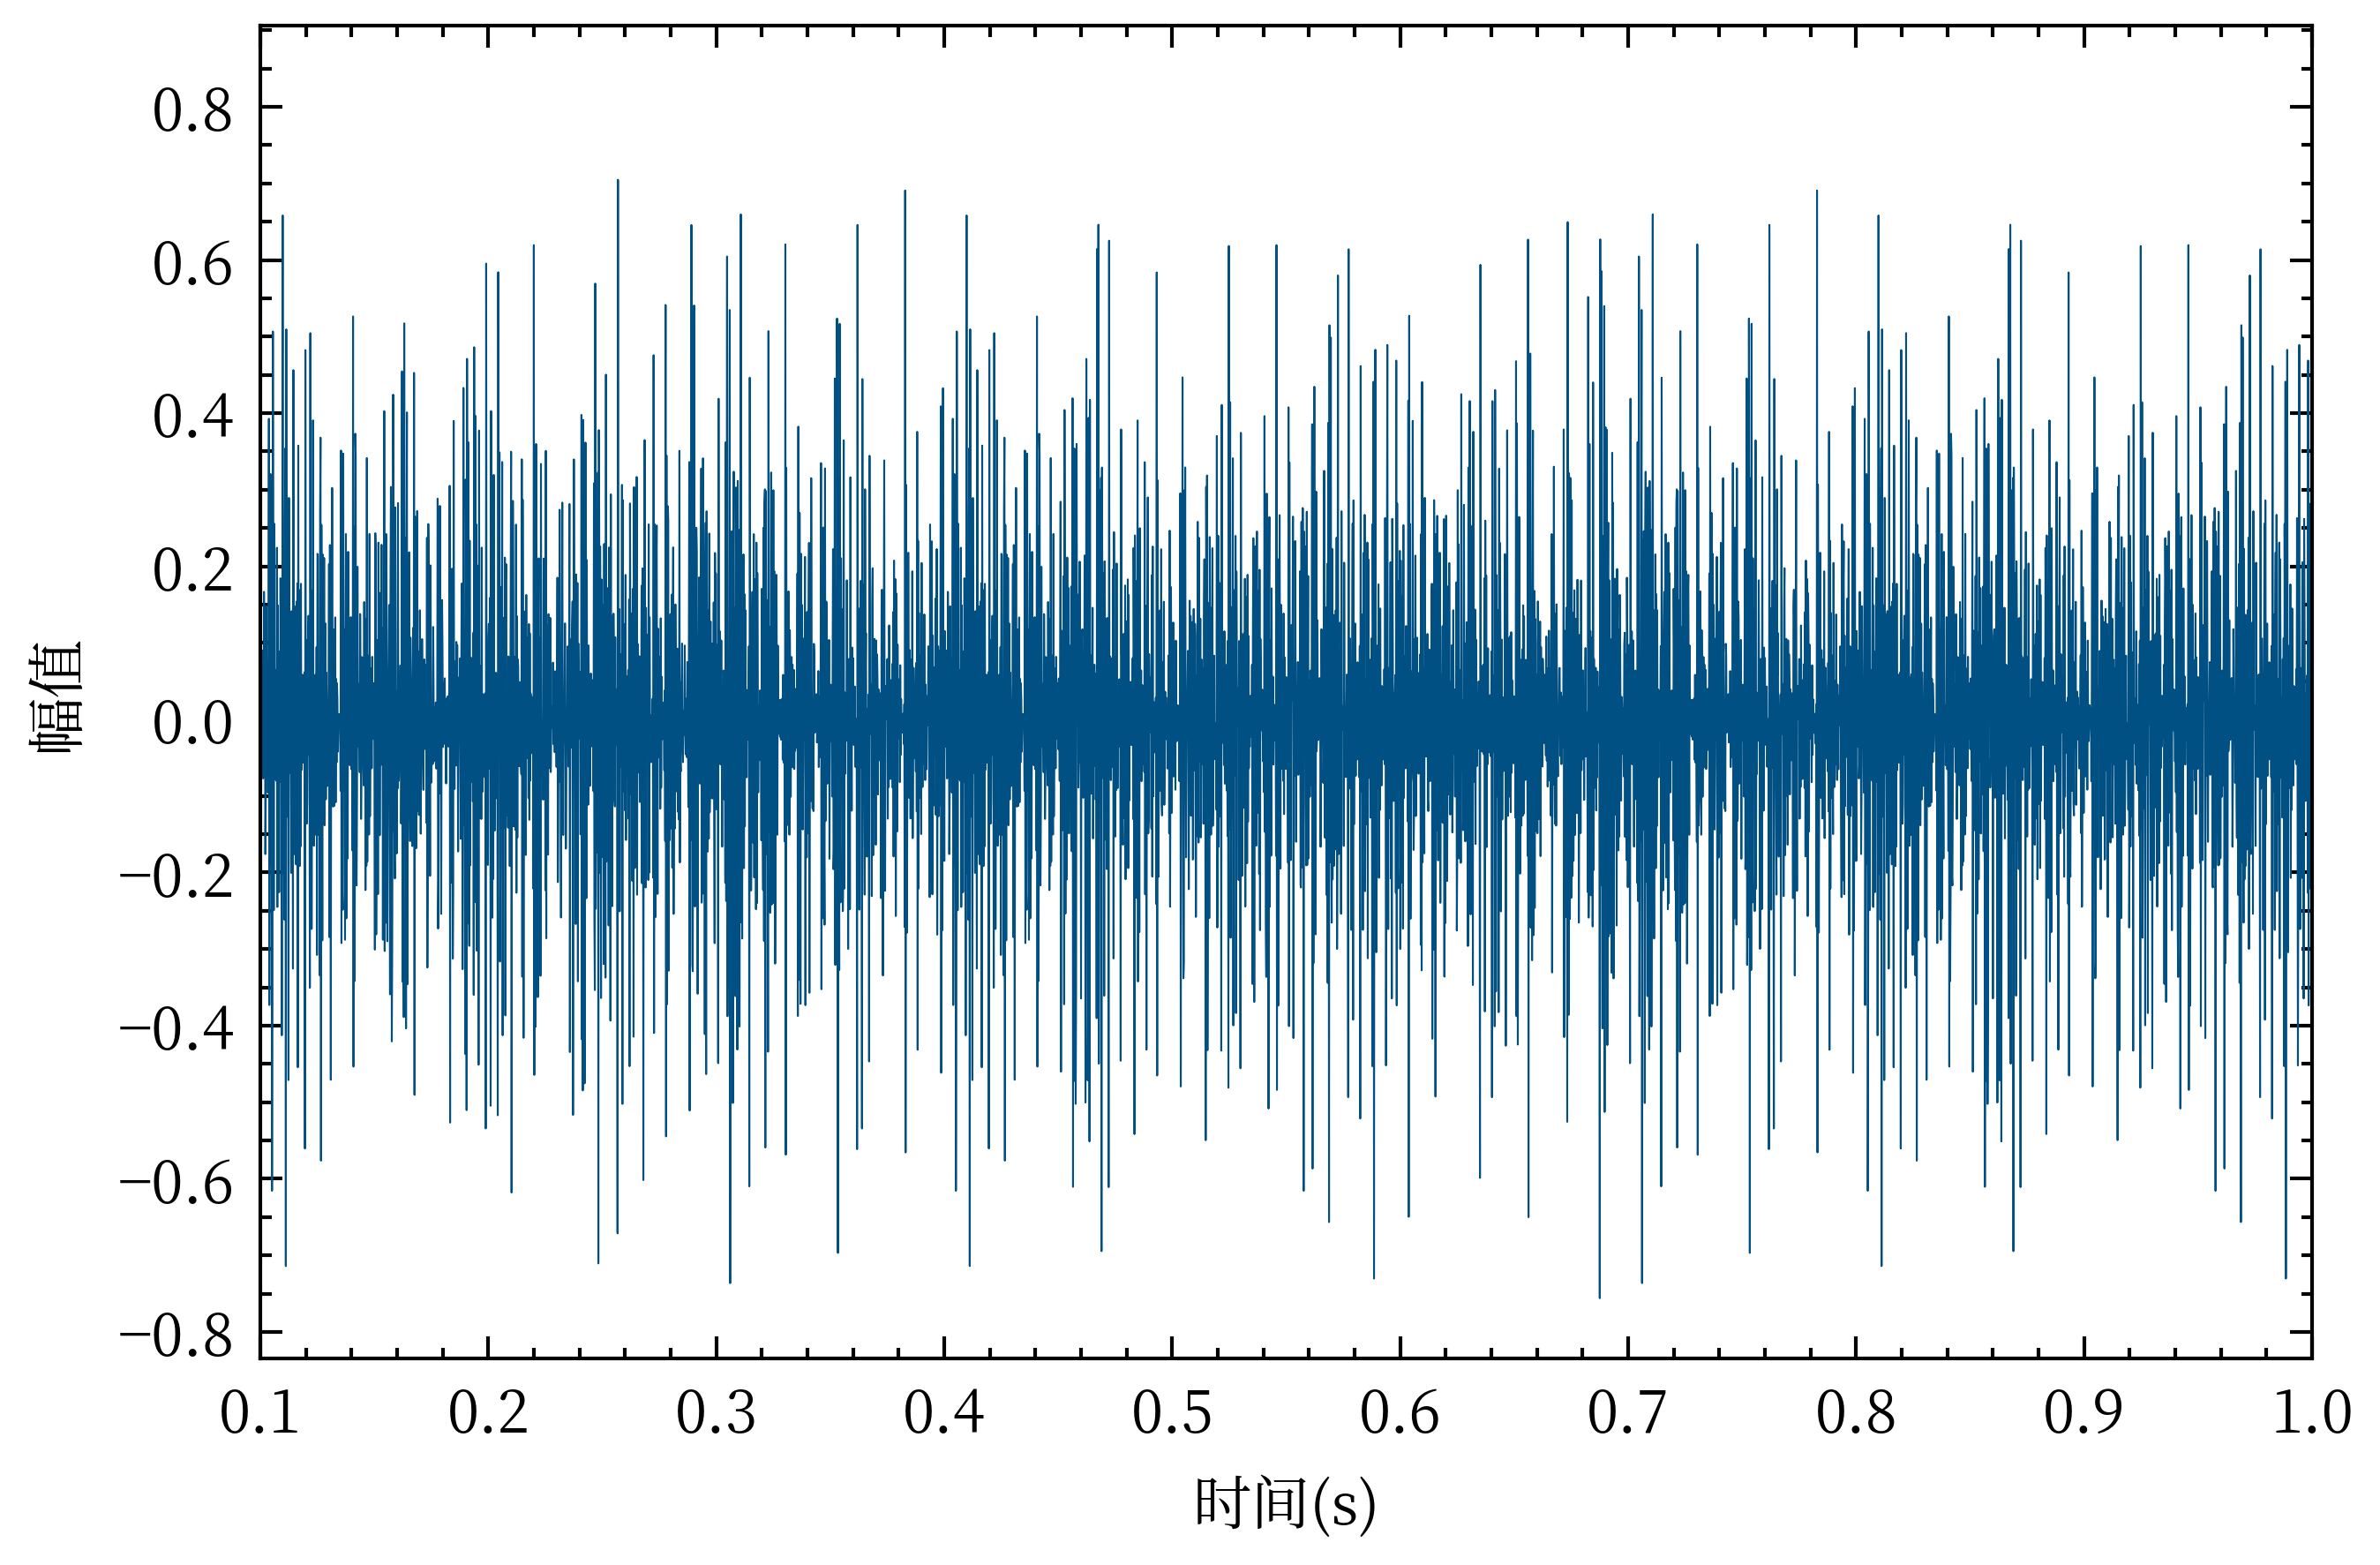

In [9]:
sheetName = 'vibration_normal'
sampling_frequency = 5120
signals = data[sheetName]
time = signals['Unnamed: 0'][500:]
sig = signals['x'][500:]

fig, ax = plt.subplots(1, 1, figsize=(6 / 1.2, 4 / 1.2), dpi=600)
ax.plot(time, sig, color=(0, 80 / 255, 131 / 255), linewidth=0.25)
ax.set_xlabel('时间(s)')
ax.set_ylabel('幅值')
ax.set_xlim(0.1, 1)
plt.savefig('figs/simulation_time_domain_normal.png', dpi=300, bbox_inches='tight',
            pad_inches=0, transparent=True)
plt.show()

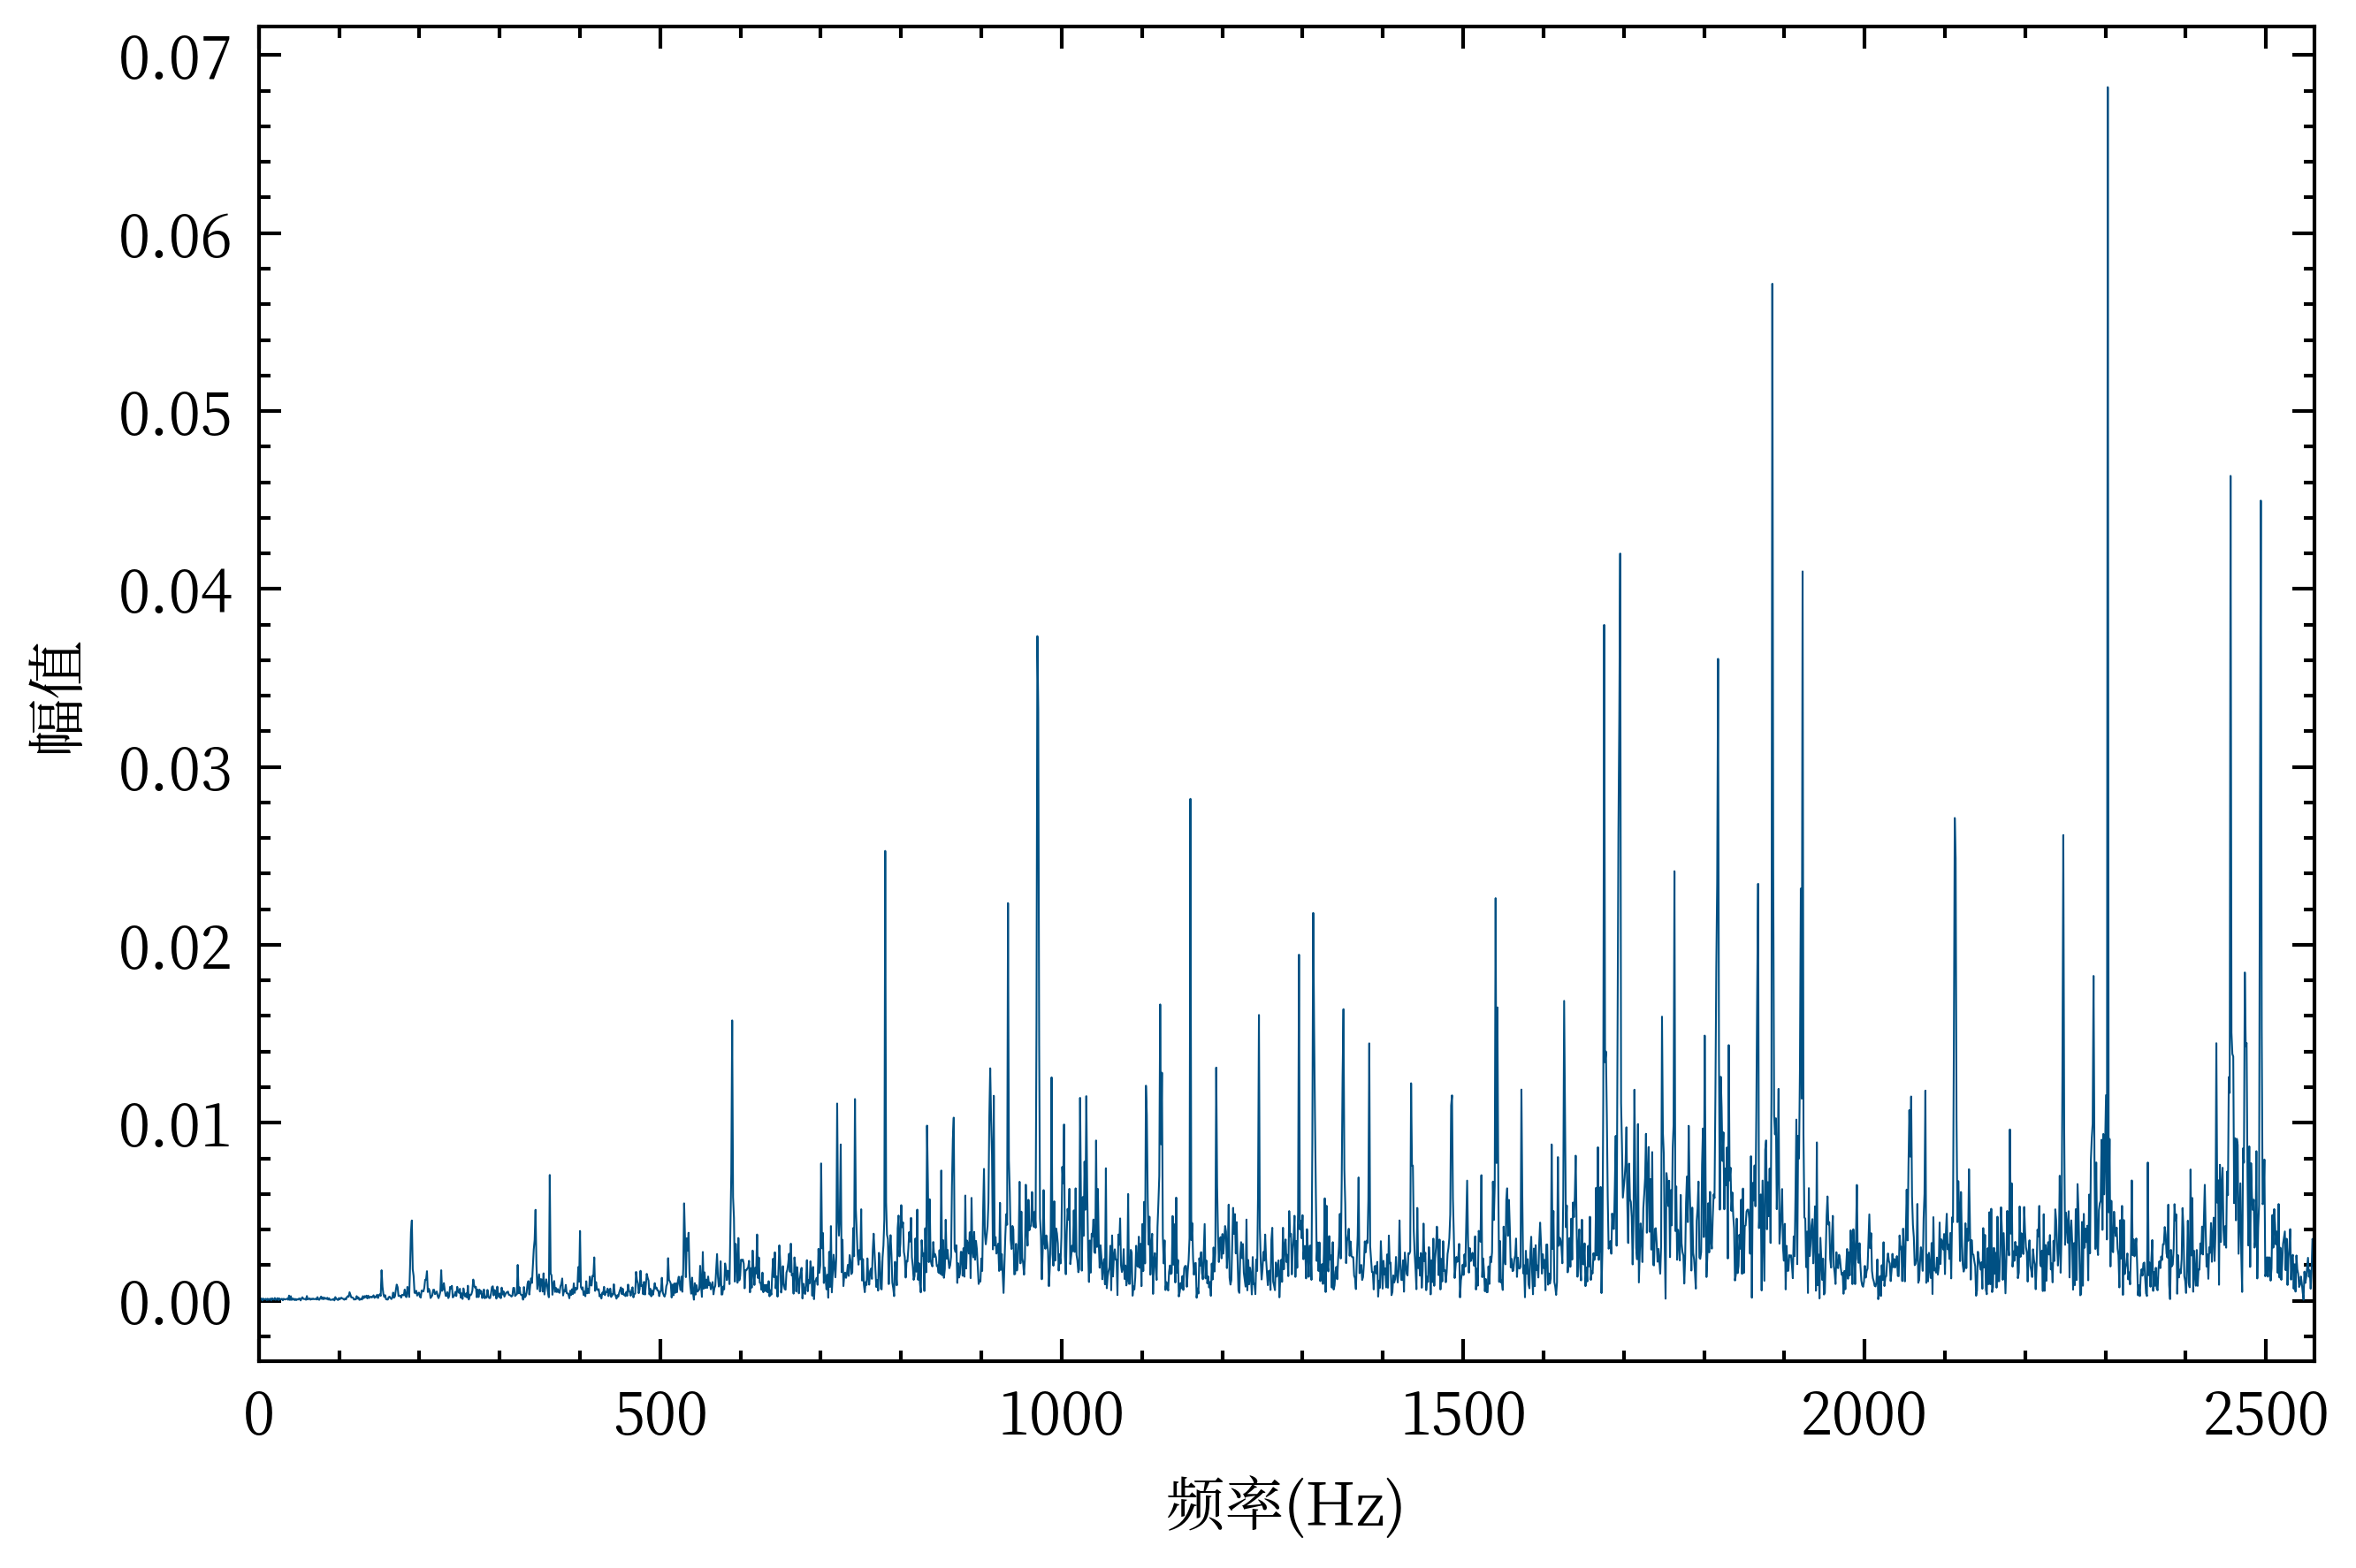

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6 / 1.2, 4 / 1.2), dpi=600)
fre, amp = FFT.fft(sig, sampling_frequency)
ax.plot(fre, amp, color=(0, 80 / 255, 131 / 255), linewidth=0.25)
ax.set_xlabel('频率(Hz)')
ax.set_ylabel('幅值')
ax.set_xlim(0, 5120 / 2)
plt.savefig('figs/simulation_frequency_domain_normal.png', dpi=300, bbox_inches='tight',
            pad_inches=0, transparent=True)

In [9]:
data.keys()

dict_keys(['big_missing_vibration', 'normal_vibration', 'small_broken_small_crack_vibrat', 'small_broken_vibration', 'small_crack_big_missing_vibrati', 'small_crack_vibration'])